In [1]:
from keras import layers, models
from __future__ import print_function
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional
import numpy as np
from keras import datasets
from keras import backend as K
from keras.utils import plot_model
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
from keras.models import load_model


batch_size = 32  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '/content/dataset.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
# 전처리
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)


# 문자 -> 숫자 변환용 사전
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

# 학습에 사용할 데이터를 담을 3차원 배열
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# 문장을 문자 단위로 원 핫 인코딩하면서 학습용 데이터를 만듬
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# 숫자 -> 문자 변환용 사전
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


# 인코더 생성
encoder_inputs = layers.Input(shape=(max_encoder_seq_length, num_encoder_tokens))
# dropout 전
# encoder = layers.GRU(latent_dim, return_sequences=True, return_state=True)

encoder = layers.GRU(latent_dim,dropout=0.25,recurrent_dropout=0.25, return_sequences=True, return_state=True)
encoder_outputs, state_h = encoder(encoder_inputs)


# 디코더 생성
decoder_inputs = layers.Input(shape=(max_decoder_seq_length, num_decoder_tokens))
# dropout 전
# decoder = layers.GRU(latent_dim, return_sequences=True, return_state=True)
decoder = layers.GRU(latent_dim,dropout=0.25,recurrent_dropout=0.25, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder(decoder_inputs, initial_state=state_h)

# attention 생성
'''
어텐션의 기본 아이디어는 디코더에서 출력 단어를 예측하는 매 시점(time step)마다, 
인코더에서의 전체 입력 문장을 다시 한 번 참고한다는 점입니다. 
단, 전체 입력 문장을 전부 다 동일한 비율로 참고하는 것이 아니라, 
해당 시점에서 예측해야할 단어와 연관이 있는 입력 단어 부분을 좀 더 
집중(attention)해서 보게 됩니다.
'''
def RepeatVectorLayer(rep, axis):
  return layers.Lambda(lambda x: K.repeat_elements(K.expand_dims(x, axis), rep, axis),
                      lambda x: tuple((x[0],) + x[1:axis] + (rep,) + x[axis:]))
# repeat_elements 함수는 1차원에 벡터에 b=[01] 이 있다고 가정하면
# repeat_elements(b, rep=2, axis=0) 이렇게 적으면 행으로 
# 0 0
# 1 1
# 이런식으로 증가


# 
# K.expand_dims 은
# K.expand_dims(n,0) 이렇게적으면 2*2 행렬이 1*2*2 행렬로
# K.expand_dims(n,1) 이렇게적으면 2*2 행렬이 2*1*2 행렬로 차원을 증가시켜줌
# 기존엔 reshape 으로 하던걸 텐서에서는 K.expand_dims를 사용
#

repeat_d_layer = RepeatVectorLayer(max_encoder_seq_length, 2)
# 입력을 n 번 반복합니다.
repeat_d = repeat_d_layer(decoder_outputs)

repeat_e_layer = RepeatVectorLayer(max_decoder_seq_length, 1)
# 입력을 n 번 반복합니다.
repeat_e = repeat_e_layer(encoder_outputs)

concat_for_score_layer = layers.Concatenate(axis=-1)
#layers.Concatenate는 입력 목록을 연결하는 계층입니다.
# 연결 축을 제외하고 모두 동일한 모양의 텐서 목록을 입력으로 사용하고 
# 모든 입력의 연결 인 단일 텐서를 반환합니다.
concat_for_score = concat_for_score_layer([repeat_d, repeat_e])

dense1_t_score_layer = layers.Dense(latent_dim // 2, activation='tanh')
# Dense 클래스 객체를 TimeDistributed wrapper를 사용하여 3차원 텐서 입력을 받을 수 있게 확장
dense1_score_layer = layers.TimeDistributed(dense1_t_score_layer)
dense1_score = dense1_score_layer(concat_for_score)


dense2_t_score_layer = layers.Dense(1)
# Dense 클래스 객체를 TimeDistributed wrapper를 사용하여 3차원 텐서 입력을 받을 수 있게 확장
dense2_score_layer = layers.TimeDistributed(dense2_t_score_layer)
dense2_score = dense2_score_layer(dense1_score)
dense2_score = layers.Reshape((max_decoder_seq_length, max_encoder_seq_length))(dense2_score)

# soft max 설정
softmax_score_layer = layers.Softmax(axis=-1)
softmax_score = softmax_score_layer(dense2_score)

# 입력을 n 번 반복합니다 RepeatVectorLayer
repeat_score_layer = RepeatVectorLayer(latent_dim, 2)
repeat_score = repeat_score_layer(softmax_score)

# layers.Permute 주어진 패턴에 따라 입력 치수를 변경합니다.
permute_e = layers.Permute((2, 1))(encoder_outputs)
repeat_e_layer = RepeatVectorLayer(max_decoder_seq_length, 1)
repeat_e = repeat_e_layer(permute_e)

attended_mat_layer = layers.Multiply() # 행렬곱
attended_mat = attended_mat_layer([repeat_score, repeat_e])

context_layer = layers.Lambda(lambda x: K.sum(x, axis=-1),
                             lambda x: tuple(x[:-1]))
context = context_layer(attended_mat)

concat_context_layer = layers.Concatenate(axis=-1)
'''입력 목록을 연결하는 계층입니다.
연결 축을 제외하고 모두 동일한 모양의 텐서 목록을 입력으로 
사용하고 모든 입력의 연결 인 단일 텐서를 반환합니다.'''
concat_context = concat_context_layer([context, decoder_outputs])

attention_dense_output_layer = layers.Dense(latent_dim, activation='tanh')
attention_output_layer = layers.TimeDistributed(attention_dense_output_layer)
attention_output = attention_output_layer(concat_context)

decoder_dense = layers.Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(attention_output)
model = models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# # 모델 생성

# che = 'atten_GRU_weight_g.h5'
# point = ModelCheckpoint(filepath=che , monitor='val_loss', verbose=1, save_best_only=True)
# early_stopping = EarlyStopping(monitor='val_loss', patience=100)
# # Run training

# model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     validation_split=0.2,
#                     verbose=1,callbacks=[point,early_stopping])
# # Save model
# model.save('atten_GRU_weight.h5')


# # 
# from keras.models import model_from_json
# json_file = open("model.json", "r")
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

model.load_weights("wh.h5")
print("Loaded model from disk")

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])


#model = load_model('/content/atten_GRU_weight_drop0.25.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# # 어텐션 검증
# test_data_num = 0
# test_max_len = 0
# for i, s in enumerate(input_texts):
#   if len(s) > test_max_len:
#     test_max_len = len(s)
#     test_data_num = i

# test_enc_input = encoder_input_data[test_data_num].reshape(
#     (1, max_encoder_seq_length, num_encoder_tokens))
# test_dec_input = decoder_input_data[test_data_num].reshape(
#     (1, max_decoder_seq_length, num_decoder_tokens))

# attention_layer = softmax_score_layer
# func = K.function([encoder_inputs, decoder_inputs] + [K.learning_phase()], [attention_layer.output])
# score_values = func([test_enc_input, test_dec_input, 1.0])[0]
# score_values = score_values.reshape((max_decoder_seq_length, max_encoder_seq_length))

# score_values = score_values[:len(target_texts[test_data_num])-1, :len(input_texts[test_data_num])]

# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(score_values, interpolation='nearest')
# fig.colorbar(cax)

# test_enc_names = []
# for vec in test_enc_input[0]:
#   sampled_token_index = np.argmax(vec)
#   sampled_char = reverse_input_char_index[sampled_token_index]
#   test_enc_names.append(sampled_char)
# test_dec_names = []
# for vec in test_dec_input[0]:
#   sampled_token_index = np.argmax(vec)
#   sampled_char = reverse_target_char_index[sampled_token_index]
#   test_dec_names.append(sampled_char)

# print(test_dec_names[1:len(target_texts[test_data_num])])

# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.set_yticklabels(['']+test_dec_names[1:-1] + ['<END>'])
# ax.set_xticklabels(['']+test_enc_names)

# plt.show()


# 모델추론단계
encoder_model = models.Model(encoder_inputs, [encoder_outputs, state_h])
encoder_outputs_input = layers.Input(shape=(max_encoder_seq_length, latent_dim))

decoder_inputs = layers.Input(shape=(1, num_decoder_tokens))
decoder_state_input_h = layers.Input(shape=(latent_dim,))
decoder_outputs, decoder_h = decoder(decoder_inputs, initial_state=decoder_state_input_h)

repeat_d_layer = RepeatVectorLayer(max_encoder_seq_length, 2)
repeat_d = repeat_d_layer(decoder_outputs)

repeat_e_layer = RepeatVectorLayer(1, axis=1)
repeat_e = repeat_e_layer(encoder_outputs_input)

concat_for_score_layer = layers.Concatenate(axis=-1)
concat_for_score = concat_for_score_layer([repeat_d, repeat_e])

dense1_score_layer = layers.TimeDistributed(dense1_t_score_layer)
dense1_score = dense1_score_layer(concat_for_score)

dense2_score_layer = layers.TimeDistributed(dense2_t_score_layer)
dense2_score = dense2_score_layer(dense1_score)
dense2_score = layers.Reshape((1, max_encoder_seq_length))(dense2_score)

softmax_score_layer = layers.Softmax(axis=-1)
softmax_score = softmax_score_layer(dense2_score)

repeat_score_layer = RepeatVectorLayer(latent_dim, 2)
repeat_score = repeat_score_layer(softmax_score)

permute_e = layers.Permute((2, 1))(encoder_outputs_input)
repeat_e_layer = RepeatVectorLayer(1, axis=1)
repeat_e = repeat_e_layer(permute_e)

attended_mat_layer = layers.Multiply()
attended_mat = attended_mat_layer([repeat_score, repeat_e])

context_layer = layers.Lambda(lambda x: K.sum(x, axis=-1),
                             lambda x: tuple(x[:-1]))
context = context_layer(attended_mat)

concat_context_layer = layers.Concatenate(axis=-1)
concat_context = concat_context_layer([context, decoder_outputs])

attention_output_layer = layers.TimeDistributed(attention_dense_output_layer)
attention_output = attention_output_layer(concat_context)

decoder_att_outputs = decoder_dense(attention_output)

decoder_model = models.Model([decoder_inputs, decoder_state_input_h, encoder_outputs_input],
                            [decoder_outputs, decoder_h, decoder_att_outputs])

def decode_sequence(input_seq):
  # 입력 문장을 인코딩
  enc_outputs, states_value = encoder_model.predict(input_seq)
 
  # 디코더의 입력으로 쓸 단일 문자
  target_seq = np.zeros((1, 1, num_decoder_tokens))
  # 첫 입력은 시작 문자인 '\t'로 설정
  target_seq[0, 0, target_token_index['\t']] = 1.
 
  # 문장 생성
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
    # 이전의 출력, 상태를 디코더에 넣어서 새로운 출력, 상태를 얻음
    # 이전 문자와 상태로 다음 문자와 상태를 얻는다고 보면 됨.
    dec_outputs, h, output_tokens = decoder_model.predict(
        [target_seq, states_value, enc_outputs])
 
    # 사전을 사용해서 원 핫 인코딩 출력을 실제 문자로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = reverse_target_char_index[sampled_token_index]
    decoded_sentence += sampled_char
 
    # 종료 문자가 나왔거나 문장 길이가 한계를 넘으면 종료
    if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
      stop_condition = True
 
    # 디코더의 다음 입력으로 쓸 데이터 갱신
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.
    
    states_value = h
 
  return decoded_sentence



Using TensorFlow backend.


Number of samples: 1175
Number of unique input tokens: 780
Number of unique output tokens: 719
Max sequence length for inputs: 165
Max sequence length for outputs: 183




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.






Loaded model from disk




In [0]:
# TEST 셋 으로 테스트

data_path_ = '/content/test.txt'

# Vectorize the data.
input_texts_ = []
target_texts_ = []

with open(data_path_, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts_.append(input_text)
    target_texts_.append(target_text)
# print(input_texts_)
# print(target_text)
# print(target_texts_)
# 학습에 사용할 데이터를 담을 3차원 배열
encoder_input_data_ = np.zeros(
    (len(input_texts_), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data_ = np.zeros(
    (len(input_texts_), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data_ = np.zeros(
    (len(input_texts_), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')


# 문장을 문자 단위로 원 핫 인코딩하면서 학습용 데이터를 만듬
for i, (input_text, target_text) in enumerate(zip(input_texts_, target_texts_)):
    for t, char in enumerate(input_text):
        encoder_input_data_[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data_[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data_[i, t - 1, target_token_index[char]] = 1.



In [3]:
# TEST 셋 확인..
test_ = []
for seq_index in range(0,len(input_texts_),1):
  
  input_seq = encoder_input_data_[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print('"{}" -> "{}"'.format(input_texts_[seq_index], decoded_sentence.strip()))
  test_.append(decoded_sentence.strip())

"﻿걸러지다 " -> "거꾸러지다"
"고른배기 " -> "호다박자"
"고쩌사다 " -> "비켜서다"
"곤작싸다 " -> "재주넘다"
"꼴성그리다 " -> "얼굴을찡그리다"
"곱지다 " -> "숨기다"
"구숭호다 " -> "불평을말하다"
"꾸러박아지다 " -> "거꾸로박히다"
"귀태우다 " -> "은밀히알려주다"
"고끼다 " -> "숨막히다"
"골메드리다 " -> "차례로바꾸다"
"늘짝거리다 " -> "늑장부리다"
"끼리다 " -> "미끄러지다"
"다울리다 " -> "재촉하다"
"댕기다 " -> "다니다"
"데껴불다 " -> "던져버리다"
"되싸지다 " -> "갈라지다"
"들럭퀴다 " -> "날 뛰다"
"몽캐다 " -> "느리다"
"몽캐다 " -> "느리다"
"베르싸다 " -> "까발리다"
"부수닥질호다 " -> "부수어버리다"
"부에나다 " -> "화나다"
"쎄울르다 " -> "고함지르다"
"소곤닥호다 " -> "소근거리다"
"무신거옌 고람신디 몰르쿠게?" -> "무엇이 말을 하고"
"게메마씀" -> "글세요"
"경해도 고만히 생각호멍 들으민 호꼼식 알라집니다." -> "그래도 가만히 생각하며 들으면 조금씩 알게  뿐이니"
"펜안하우꽈?" -> "안녕하십니까?"
"제주도에 오난 어떵 하우꽈?" -> "제주도에 오니 어떠하십니까?"
"산이영 바당이영 몬딱 좋은게 마씀." -> "공기도 맑고이 산이랑 바다랑 모두이 좋습니다."
"저기 물허벅 정가는 거" -> "아기 잘지 아니가 말해도 못하고 아기 보려네"
"맞수다. 비바리도 있고" -> "맞습니다."
"날 얼마나 소랑햄쑤과?" -> "무나 좋어 사람 얼굴 안하십니까?"
"저기 한락산만큼" -> "들고 이며 놀았다고 해서 울다."
"이 조끄뜨레만 오라게" -> "당이 아무서 가십시오"
"무사 조끄뜨레만 오랜 햄수과?" -> "왜 그렇게 말하십니까?"
"호꼼 이라도 고치만 있고싶언." -> "조금만 계십시오."
"둥구리멍 질룬 독새기가 빙애기 된댕 혼다." -> "뒹글리면서 기른 달걀이 병아리가 된다고 한다."
"혼

In [0]:
result= []
for seq_index in range(0,len(input_texts),1):
  
  input_seq = encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  #print('"{}" -> "{}"'.format(input_texts[seq_index], decoded_sentence.strip()))
  result.append(decoded_sentence.strip())

target_texts2 = []

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    _, target_text2 = line.split('\t')
    target_text2 = target_text2
    target_texts2.append(target_text2)
    # for char in target_text2:
    #     if char not in target_characters:
    #         target_characters.add(char)

In [0]:
tar = target_texts2[0:len(input_texts)]
#tar

In [10]:
# https://donghwa-kim.github.io/BLEU.html
def dap(result, tar):
  import nltk.translate.bleu_score as bleu
  candidate = []
  references = []
  dap = []
  dd = []
  for i in range(0,len(result)):
    re = []
    candidate = result[i]
    re.append(tar[i])
    dap.append(bleu.sentence_bleu(list(map(lambda ref: ref.split(), re)),candidate.split()))
    if i % 10 == 0:
      dd.append(bleu.sentence_bleu(list(map(lambda ref: ref.split(), re)),candidate.split()))
      #print("예측값:",candidate,'//',"실제값:",re,"Bleu 점수:",dd)
      dd=[]
  return sum(dap)/len(result)
# 성능테스트
print('전체점수 : ', dap(result,tar))

전체점수 :  0.7779943380425913


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [0]:
# Test Bleu 점수

In [0]:
target_texts1 = []

with open(data_path_, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    _, target_text1 = line.split('\t')
    target_text1 = target_text1
    target_texts1.append(target_text1)
    # for char in target_text2:
    #     if char not in target_characters:
    #         target_characters.add(char)

tar_ = target_texts1[0:len(input_texts_)]

In [5]:
def dap2(test_, tar_):
  import nltk.translate.bleu_score as bleu
  candidate = []
  references = []
  dap = []
  dd = []
  for i in range(0,len(test_)):
    re = []
    candidate = test_[i]
    re.append(tar_[i])
    dap.append(bleu.sentence_bleu(list(map(lambda ref: ref.split(), re)),candidate.split()))
    # if i % 10 == 0:
    #   dd.append(bleu.sentence_bleu(list(map(lambda ref: ref.split(), re)),candidate.split()))
    #   print("예측값:",candidate,'//',"실제값:",re,"Bleu 점수:",dd)
    #   dd=[]
  return sum(dap)/len(test_)
# 성능테스트
print('전체점수 : ', dap2(test_,tar_))

전체점수 :  0.6404671151318605


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0, flags=flags)


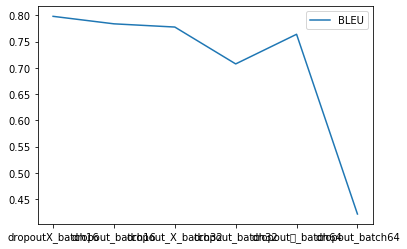

In [0]:
import matplotlib.pyplot as plt
plt.plot(bleu, label='BLEU')
#plt.plot(model.history.history['val_loss'], 'r', label='val loss')
plt.legend(loc='upper right')
plt.show()

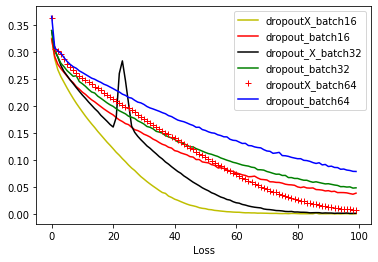

In [0]:
plt.plot(loss['dropoutX_batch16'], 'y', label='dropoutX_batch16')
plt.plot(loss['dropout_batch16'], 'r', label='dropout_batch16')
plt.plot(loss['dropout_X_batch32'], 'black', label='dropout_X_batch32')
plt.plot(loss['dropout_batch32'], 'g', label='dropout_batch32')
plt.plot(loss['dropoutX_batch64'], 'r+', label='dropoutX_batch64')
plt.plot(loss['dropout_batch64'], 'b', label='dropout_batch64')
plt.legend(loc='upper right')
plt.xlabel("Loss")
plt.show()

In [0]:
import nltk.translate.bleu_score as bleu

# 예측값
candidate = '따뜻합니까?'

# 정답값
references = ['따뜻합니까?']

print(bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),candidate.split()))
# NLTK 패키지 구현되어져 있는 코드로 계산한 BLEU 점수

1.0


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
